In [1]:
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torch.nn.functional as F

In [3]:
import sys
sys.path.append("../")

In [4]:
from utils.data import BanditDataset
from alg.iw import IW
from alg.q import QLearning

In [5]:
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12) 
rc('legend', fontsize=12) 
rc('axes', titlesize=16, labelsize=18) 

rc('pdf', fonttype=42)
rc('ps', fonttype=42)

In [6]:
def get_df(alg, lr, n, d, K, gamma, epsilon, seed, action_seed):
    file_name = 'stability_sweep_alg=' + alg + \
                            '_lr=' + str(lr) + '_n=' + str(n) + '_d=' + str(d) + \
                            '_K=' + str(K) + \
                            '_gamma=' + str(gamma) + '_epsilon=' + str(epsilon) + \
                            '_dataseed=' + str(seed) + '_actionseed=' + str(action_seed)
    s = Store('../cox_logs', file_name, mode='r')
    df = s['learning_curves'].df
    s.close()
    return df

In [7]:
def get_data(mode, n, d, K, nbad, gamma, epsilon, seed, action_seed):
    
    dataset = BanditDataset(None, None, None, None, None, None)
    
    path = '../data/synth/n=' + str(n) + '/d=' + str(d) + '/K=' + str(K) + \
                '/nbad=' + str(nbad) + '/gamma=' + str(gamma) + \
                '/epsilon=' + str(epsilon) + '/seed=' + str(seed) + '/action_seed=' + str(action_seed)
    dataset.load(path + '/' + mode + '.pt')
    return dataset

def get_opt_and_rand(mode, n, d, K, nbad, gamma, epsilon, seed, action_seed):
    data = get_data(mode, n, d, K, nbad, gamma, epsilon, seed, action_seed)
    opt = torch.mean(torch.gather(data.rewards, dim=1, index=data.labels.unsqueeze(1)))
    rand = torch.mean(data.rewards)
    return opt, rand

def get_ave_opt_and_rand(mode, n, d, K, nbad, gamma, epsilon):
    opt, rand = 0,0
    seed = 0
    for action_seed in range(5):
        o,r = get_opt_and_rand(mode, n, d, K, nbad, gamma, epsilon, seed, action_seed)
        opt += o
        rand += r
    return opt / 5, rand / 5

In [8]:
def load_model(epoch, alg, lr, n, d, K, gamma, epsilon, seed, action_seed):
    file_name = 'stability_sweep_alg=' + alg + \
                            '_lr=' + str(lr) + '_n=' + str(n) + '_d=' + str(d) + \
                            '_K=' + str(K) + \
                            '_gamma=' + str(gamma) + '_epsilon=' + str(epsilon) + \
                            '_dataseed=' + str(seed) + '_actionseed=' + str(action_seed)
    path = '../models/' + file_name + '_' + str(epoch) + '.pt'
    
    if alg == 'iw':
        model = IW(clip=None, context_dim=d, num_actions=K, 
                          model_type='mlp', n_hidden=512)
    if alg == 'q':
        model = QLearning(context_dim=d, num_actions=K, 
                          model_type='mlp', n_hidden=512)
    model.load(path)
    return model

In [9]:
def get_lc(df, mode, quantity):
    lc = df[df['mode'] == mode][quantity].to_numpy()
    return lc

In [10]:
def l1_div(pi1, pi2):
    l1 = torch.sum(torch.abs(pi1 - pi2), dim=-1)
    return torch.mean(l1)

In [11]:
def get_final(mode, quantity, alg, lr, n, d, K, gamma, epsilon, seed, action_seed):
    df = get_df(alg, lr, n, d, K, gamma, epsilon, seed, action_seed)
    lc = get_lc(df, mode, quantity)
    return lc[-1]

In [12]:
def get_final_list(n_seeds, mode, quantity, alg, lr, n, d, K, gamma, epsilon):
    out = []
    for s in range(1, n_seeds+1):
        out.append(get_final(mode, quantity, alg, lr, n, d, K, gamma, epsilon, s, 0))
    return np.array(out)

In [13]:
def get_opt_list(n_seeds, mode, n, d, K, nbad, gamma, epsilon):
    out = []
    for s in range(1, n_seeds+1):
        o, r = get_opt_and_rand(mode, n, d, K, nbad, gamma, epsilon, s, 0)
        out.append(o)
    return np.array(out)

In [14]:
# global notebook parameters

n = 100
d = 10
K = 2
nbad = 0
epsilon = 0.1
gamma = 0.0
seed = 0

In [15]:
lr=0.01
data = get_data('test', n, d, K, nbad, gamma, epsilon, seed, 0)

n_seeds = 20

policy_corr_mat = np.zeros((n_seeds,n_seeds))

for i in range(n_seeds):
    for j in range(n_seeds):
        pi1 = load_model(1000, 'iw', lr, n, d, K, gamma, epsilon, seed, i)
        pi2 = load_model(1000, 'iw', lr, n, d, K, gamma, epsilon, seed, j)
        policy_corr_mat[i,j] = l1_div(pi1.model(data.contexts).exp(), 
                               pi2.model(data.contexts).exp())

lr=0.01
data = get_data('test', n, d, K, nbad, gamma, epsilon, seed, 0)

value_corr_mat = np.zeros((n_seeds,n_seeds))

for i in range(n_seeds):
    for j in range(n_seeds):
        Q1 = load_model(1000, 'q', lr, n, d, K, gamma, epsilon, seed, i)
        Q2 = load_model(1000, 'q', lr, n, d, K, gamma, epsilon, seed, j)
        pi1 = 1.0 * F.one_hot(torch.argmax(Q1.model(data.contexts), dim=-1) , K)
        pi2 = 1.0 * F.one_hot(torch.argmax(Q2.model(data.contexts), dim=-1) , K)
        value_corr_mat[i,j] = l1_div(pi1, pi2)

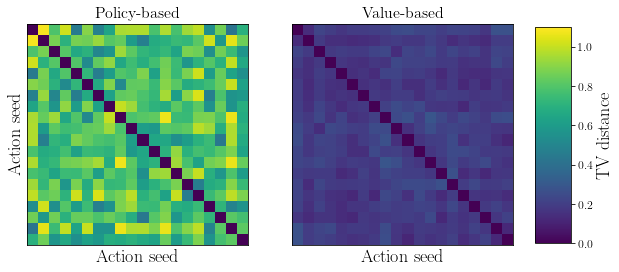

In [16]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(policy_corr_mat, vmin=0, vmax=1.1)
im = axes[1].imshow(value_corr_mat, vmin=0, vmax=1.1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.05, 0.6])
fig.colorbar(im, cax=cbar_ax, label='TV distance')

axes[0].set_yticklabels([])
axes[0].set_yticks([])
axes[0].set_xticklabels([])
axes[0].set_xticks([])
axes[1].set_yticklabels([])
axes[1].set_yticks([])
axes[1].set_xticklabels([])
axes[1].set_xticks([])

axes[0].set_xlabel('Action seed')
axes[1].set_xlabel('Action seed')
axes[0].set_ylabel('Action seed')

axes[0].set_title('Policy-based')
axes[1].set_title('Value-based')

plt.savefig('toy_stability.pdf', dpi=300, bbox_inches='tight')
plt.show()

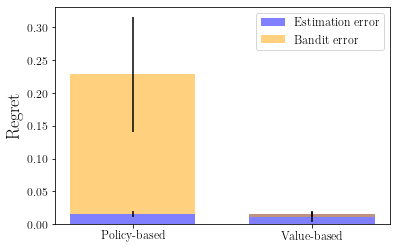

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

mode = 'test'
quantity = 'reward'
lr = 0.01

n_seeds = 50

iw = get_final_list(n_seeds, 'test', 'reward', 'iw', lr, n, d, K, gamma, epsilon)
q = get_final_list(n_seeds, 'test', 'reward', 'q', lr, n, d, K, gamma, epsilon)
ff = get_final_list(n_seeds, 'test', 'reward', 'ff', lr, n, d, K, gamma, epsilon)
opt = get_opt_list(n_seeds, 'test', n, d, K, nbad, gamma, epsilon)

# decompose regret (opt - ff) + (ff - alg)
ee = np.mean(opt - ff)
ee_std = np.std(opt - ff)

iw_be = np.mean(ff - iw)
iw_be_std = np.std(ff - iw)
q_be = np.mean(ff - q)
q_be_std = np.std(ff - q)


axes.bar(0, ee, color='blue', label='Estimation error', width=0.7, alpha=0.5, yerr=ee_std)
axes.bar(0, iw_be, bottom=ee, color='orange', label='Bandit error', width=0.7, alpha=0.5, yerr=iw_be_std)

axes.bar(1, ee, color='blue', width=0.7, alpha=0.5, yerr=ee_std)
axes.bar(1, q_be, bottom=ee, color='orange', width=0.7, alpha=0.5, yerr=q_be_std)

axes.set_ylabel('Regret')
axes.set_xticks([0,1])
axes.set_xticklabels(['Policy-based', 'Value-based'])

axes.legend()
plt.savefig('toy_regret_bar.pdf', dpi=300)
plt.show()

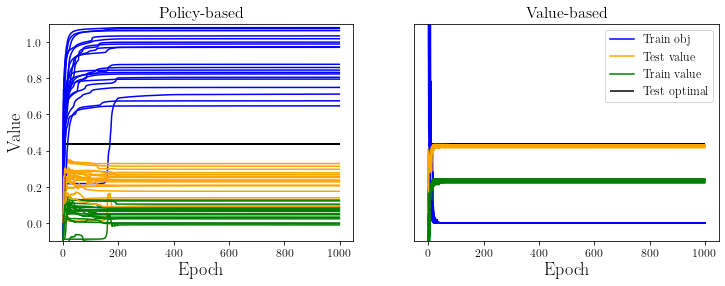

In [19]:
lr = 0.01
seed = 0
#a_s = 1

n_seeds = 20

def plot_lc(df, ax, pb, label):
    lc = get_lc(df, 'train', 'loss')
    if label:
        if pb:
            ax.plot(-lc, color='blue', label='Train obj')
        else:
            ax.plot(lc, color='blue', label='Train obj')

        lc = get_lc(df, 'test', 'reward')
        ax.plot(lc, color='orange', label='Test value')

        opt, rand = get_opt_and_rand("test", n, d, K, nbad, gamma, epsilon, seed, a_s)
        ax.hlines(opt, 0,1000, label='Test optimal', color='black')

        lc = get_lc(df, 'train', 'reward')
        ax.plot(lc, color='green', label='Train value')
    else:
        if pb:
            ax.plot(-lc, color='blue')
        else:
            ax.plot(lc, color='blue')

        lc = get_lc(df, 'test', 'reward')
        ax.plot(lc, color='orange')

        opt, rand = get_opt_and_rand("test", n, d, K, nbad, gamma, epsilon, seed, a_s)
        ax.hlines(opt, 0,1000, color='black')

        lc = get_lc(df, 'train', 'reward')
        ax.plot(lc, color='green')
    

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for a_s in range(n_seeds):
    df = get_df('iw', lr, n, d, K, gamma, epsilon, seed, a_s)
    plot_lc(df, axes[0], True, False)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Value')
axes[0].set_title('Policy-based')
axes[0].set_ylim(-0.1, 1.1)

for a_s in range(n_seeds):
    df = get_df('q', lr, n, d, K, gamma, epsilon, seed, a_s)
    if a_s ==0:
        plot_lc(df, axes[1], False, True)
    else:
        plot_lc(df, axes[1], False, False)
axes[1].set_xlabel('Epoch')
axes[1].set_yticklabels([])
axes[1].set_yticks([])
axes[1].legend(loc='upper right')
axes[1].set_title('Value-based')
axes[1].set_ylim(-0.1, 1.1)
    
plt.savefig('toy_learning.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
def iw_ave_correlation(lr, n, d, K, nbad, gamma, epsilon, seed):
    data = get_data('test', n, d, K, nbad, gamma, epsilon, seed, 0)

    policy_corr_mat = np.zeros((5,5))

    for i in range(5):
        for j in range(5):
            pi1 = load_model(1000, 'iw', lr, n, d, K, gamma, epsilon, seed, i)
            pi2 = load_model(1000, 'iw', lr, n, d, K, gamma, epsilon, seed, j)
            policy_corr_mat[i,j] = l1_div(pi1.model(data.contexts).exp(), 
                                   pi2.model(data.contexts).exp())
    
    ave_corr = np.sum(policy_corr_mat) / 20
    return ave_corr

def q_ave_correlation(lr, n, d, K, nbad, gamma, epsilon, seed):
    data = get_data('test', n, d, K, nbad, gamma, epsilon, seed, 0)

    value_corr_mat = np.zeros((5,5))

    for i in range(5):
        for j in range(5):
            Q1 = load_model(1000, 'q', lr, n, d, K, gamma, epsilon, seed, i)
            Q2 = load_model(1000, 'q', lr, n, d, K, gamma, epsilon, seed, j)
            pi1 = 1.0 * F.one_hot(torch.argmax(Q1.model(data.contexts), dim=-1) , K)
            pi2 = 1.0 * F.one_hot(torch.argmax(Q2.model(data.contexts), dim=-1) , K)
            value_corr_mat[i,j] = l1_div(pi1, pi2)
    
    ave_corr = np.sum(value_corr_mat) / 20
    return ave_corr

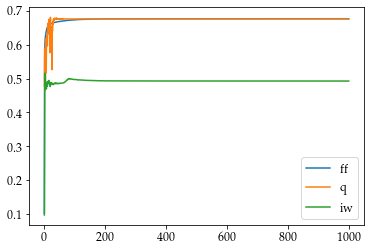

In [49]:
algs = ['ff', 'q', 'iw']
mode = 'test'
quantity = 'reward'
lr = 0.01

seed = 5

for alg in algs:
    df = get_df(alg, lr, n, d, K, gamma, epsilon, seed, 0)
    lc = get_lc(df, mode, quantity)
    plt.plot(lc, label=alg)
plt.legend()
plt.show()

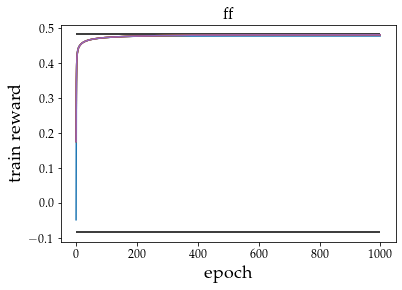

In [38]:
alg = 'ff'
mode = 'train'
quantity = 'reward'

lr = 0.01

for a_s in range(5):
    df = get_df(alg, lr, n, d, K, gamma, epsilon, seed, a_s)
    lc = get_lc(df, mode, quantity)
    plt.plot(lc)
    
opt, rand = get_ave_opt_and_rand(mode, n, d, K, nbad, gamma, epsilon)
plt.hlines(opt, 0,1000, label='opt', color='black')
plt.hlines(rand, 0,1000, label='rand', color='black')

plt.xlabel('epoch')
plt.ylabel(mode + ' ' + quantity)
plt.title(alg)
#plt.ylim(0.45, 0.5)
plt.show()